In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
import nltk
from nltk.tokenize import word_tokenize, MWETokenizer

# got tired of warnings 🙃
import warnings
warnings.filterwarnings('ignore')

# Only need to run once
# nltk.download('punkt')

## Import Data from CSV

In [2]:
data_url = "gsearch_jobs.csv"
jobs_all = pd.read_csv(data_url).replace("'","", regex=True)
jobs_all.date_time = pd.to_datetime(jobs_all.date_time) # convert to date time
jobs_all = jobs_all.drop(labels=['Unnamed: 0', 'index'], axis=1, errors='ignore')
jobs_all.description_tokens = jobs_all.description_tokens.str.strip("[]").str.split(",")

## Data Integrity Check

In [3]:
print("Big Query Statistics:")
print("---------------------")
print(f"Rows of data: {len(jobs_all)}")

repeat_jobs = jobs_all.job_id.value_counts()
try:
    repeat_jobs = repeat_jobs[repeat_jobs>1].index[0]
    repeat_jobs = len(repeat_jobs)
except IndexError:
    repeat_jobs = "None"
print(f"Number jobs repeated: {repeat_jobs}")

first_date = jobs_all.date_time.dt.date.min()
today_date = datetime.date.today() #+ datetime.timedelta(days=2) # test function works
date_count = pd.DataFrame(jobs_all.date_time.dt.date.value_counts())
missing_dates = list(pd.date_range(start=first_date, end=today_date).difference(date_count.index))
if len(missing_dates) > 0:
    print("Missing data for following dates:")
    for date in missing_dates:
        print(date)
else:
    print(f"No missing dates of data since inception of: {first_date}")

delta_days = (today_date - (first_date - datetime.timedelta(days=2))).days # first day was actually day prior but UTC
jobs_day = round(len(jobs_all)/delta_days)
print(f"Average number of jobs per day: {jobs_day}")
print(f"Collecting data for {delta_days} days now...")

Big Query Statistics:
---------------------
Rows of data: 1820
Number jobs repeated: None
Missing data for following dates:
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-03 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00
2022-12-10 00:00:00
2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-17 00:00:00
2022-12-18 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00
2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00
2022-12-31 00:00:00
2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00

## Exploratory Data Analysis

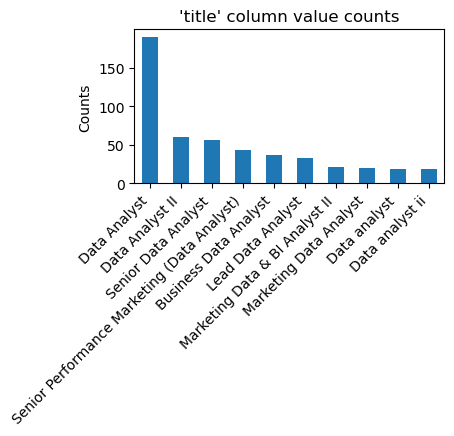

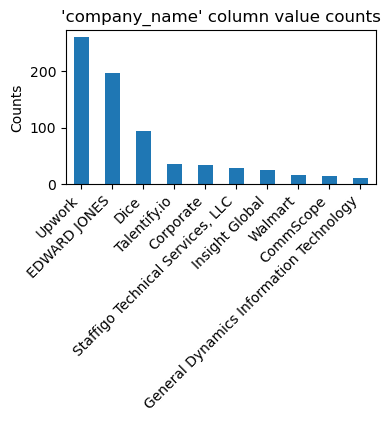

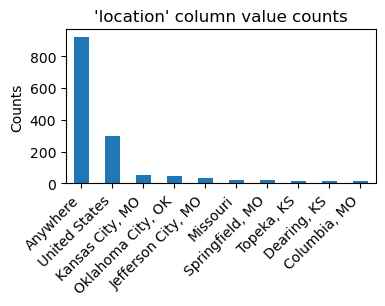

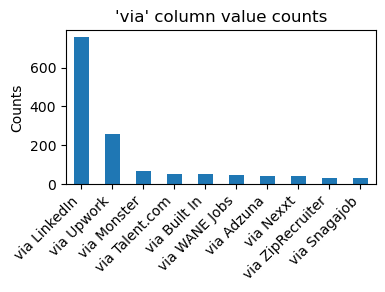

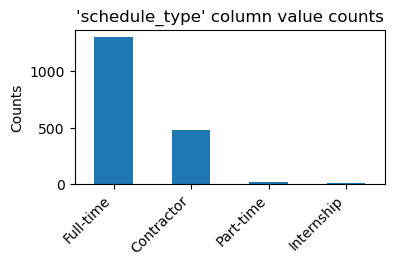

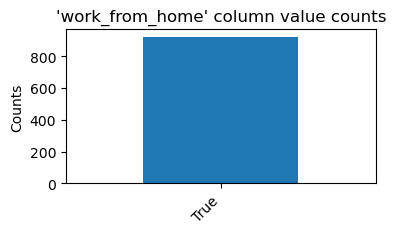

In [4]:
def eda_plot(column, topn=10):
    plt.figure(figsize=(4, 2))
    jobs_all[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 45, ha='right')
    plt.show()

columns = ['title', 'company_name', 'location', 'via', 'schedule_type', 'work_from_home']

for column in columns:
    eda_plot(column)

## Data Cleaning

### Salary Cleaning

In [5]:
# Separate 'salary' column into that for min max avg and rate (e.g., hourly)
jobs_all[['salary_pay', 'salary_rate']] = jobs_all.salary.str.split(' ', 1, expand=True)
jobs_all.salary_pay = jobs_all.salary_pay.str.replace(',', '').str.replace('$', '').str.replace(' ', '')
jobs_all['salary_avg'] = np.where(jobs_all.salary_pay.str.contains("–"), np.NaN, jobs_all.salary_pay)  # The character U+2013 "–" could be confused with the character U+002d "-", which is more common in source code. Adjust settings
jobs_all['salary_min'] = np.where(jobs_all.salary_pay.str.contains("–"), jobs_all.salary_pay, np.NaN)
jobs_all[['salary_min', 'salary_max']] = jobs_all.salary_min.str.split("–", 1, expand=True)
for column in ['salary_avg', 'salary_min', 'salary_max']:
    jobs_all[column] = np.where(jobs_all[column].str.contains("K"), jobs_all[column].str.replace("K", "").astype(float) * 1000 , jobs_all[column] )
jobs_all['salary_avg'] = np.where(~jobs_all.salary_min.isnull(), (jobs_all.salary_min.astype(float) + jobs_all.salary_max.astype(float))/2 , jobs_all.salary_avg)
jobs_all['salary_hourly'] = np.where(jobs_all.salary_rate == 'an hour', jobs_all.salary_avg.astype(float), np.NaN)
jobs_all['salary_yearly'] = np.where(jobs_all.salary_rate == 'a year', jobs_all.salary_avg.astype(float), np.NaN)

# Standardize salary to all be annual
jobs_all['salary_standardized'] = np.NaN
salary_rate = {'a year': 1, 'an hour': 2080, 'a month': 12}
for key, index in salary_rate.items():
    jobs_all.salary_standardized = np.where(jobs_all.salary_rate == key, jobs_all.salary_avg.astype(float) * index, jobs_all.salary_standardized)

# Used to check results as built above
salary_df = jobs_all[~jobs_all.salary.isnull()]
salary_df = salary_df[['company_name', 'salary', 'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max', 'salary_standardized', 'salary_hourly', 'salary_yearly']] #, 'salary_min', 'salary_max']
pd.set_option('display.max_rows', salary_df.shape[0]+1)
salary_df.head(10)

,company_name,salary,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_standardized,salary_hourly,salary_yearly
1,Harnham,60–70 an hour,60–70,an hour,65.0,60,70,135200.000,65.0,NaN
4,Cyber Resource,"68,694.19–133,665.00 a year",68694.19–133665.00,a year,101179.595,68694.19,133665.00,101179.595,NaN,101179.595
10,United States Steel,20 an hour,20,an hour,20,NaN,None,41600.000,20.0,NaN
12,Elite Insurance Partners,60K a year,60K,a year,60000.0,NaN,None,60000.000,NaN,60000.000
16,Consultis,45–50 an hour,45–50,an hour,47.5,45,50,98800.000,47.5,NaN
23,CommScope,67K–83.7K a year,67K–83.7K,a year,75350.0,67000.0,83700.0,75350.000,NaN,75350.000
25,CommScope,67K–83.7K a year,67K–83.7K,a year,75350.0,67000.0,83700.0,75350.000,NaN,75350.000
31,1 point system,55–60 an hour,55–60,an hour,57.5,55,60,119600.000,57.5,NaN
32,Precision Technology,"47,546.74–110,472.90 a year",47546.74–110472.90,a year,79009.82,47546.74,110472.90,79009.820,NaN,79009.820
35,DevCare solutions,47–55 an hour,47–55,an hour,51.0,47,55,106080.000,51.0,NaN


In [6]:
jobs_all

,title,company_name,location,via,description,extensions,job_id,thumbnail,posted_at,schedule_type,...,commute_time,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens
0,Enterprise Portfolio Data Analyst,Children’s Mercy Kansas City,"Kansas City, MO",via AARP Job Board,Thanks for your interest in Childrens Mercy!\n...,"[22 hours ago, Full-time]",eyJqb2JfdGl0bGUiOiJFbnRlcnByaXNlIFBvcnRmb2xpby...,https://encrypted-tbn0.gstatic.com/images?q=tb...,22 hours ago,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,Senior Content Data Analyst (Video Streaming),Harnham,United States,via WJHL Jobs,Senior Content Analyst\n\n12 Month Contract to...,"[16 hours ago, 60–70 an hour, Full-time, No de...",eyJqb2JfdGl0bGUiOiJTZW5pb3IgQ29udGVudCBEYXRhIE...,NaN,16 hours ago,Full-time,...,NaN,60–70,an hour,65.0,60,70,65.0,NaN,135200.000,"[sql, excel, python]"
2,Business Data Analyst,Lockton,"Kansas City, MO",via Lockton - Talentify,We are looking for a Business Data Analyst who...,"[11 hours ago, Full-time]",eyJqb2JfdGl0bGUiOiJCdXNpbmVzcyBEYXRhIEFuYWx5c3...,https://encrypted-tbn0.gstatic.com/images?q=tb...,11 hours ago,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[r, sql, azure, python]"
3,PowerBI Data Analyst,Mitchell Martin Inc,United States,via Mitchell Martin Jobs,"Our client, the leading international insuranc...","[18 hours ago, Full-time, No degree mentioned]",eyJqb2JfdGl0bGUiOiJQb3dlckJJIERhdGEgQW5hbHlzdC...,https://encrypted-tbn0.gstatic.com/images?q=tb...,18 hours ago,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[power_bi]
4,Sr SaaS Business Analyst,Cyber Resource,United States,via Central Illinois Proud Jobs,Job Title: Sr SaaS Business Analyst\nDuration:...,"[3 hours ago, 68,694.19–133,665.00 a year, Ful...",eyJqb2JfdGl0bGUiOiJTciBTYWFTIEJ1c2luZXNzIEFuYW...,NaN,3 hours ago,Full-time,...,NaN,68694.19–133665.00,a year,101179.595,68694.19,133665.00,NaN,101179.595,101179.595,"[sql, jira]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,Senior Performance Marketing (Data Analyst),EDWARD JONES,"Boonville, MO",via Vacancies For Stevenage Fans,"At Edward Jones, we help clients achieve their...","[6 hours ago, Full-time]",eyJqb2JfdGl0bGUiOiJTZW5pb3IgUGVyZm9ybWFuY2UgTW...,NaN,6 hours ago,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[spss, python, sas, pl/sql, nosql, tablea..."
1816,"Data Analyst, Developer Operations",Meta,"Oklahoma City, OK",via Vacancies For Stevenage Fans,"Summary:\n\nMeta Platforms, Inc. (Meta), forme...","[13 hours ago, Full-time]",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QsIERldmVsb3...,NaN,13 hours ago,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[python, scikit-learn, tableau, dplyr, sql..."
1817,Data Science/Data Analyst Internship - Summer ...,Koch Industries,"Wichita, KS",via Vacancies For Stevenage Fans,Description\n\nWho are we...\n\nAt Koch Indust...,"[13 hours ago, Full-time, Health insurance]",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UvRGF0YSBBbm...,https://encrypted-tbn0.gstatic.com/images?q=tb...,13 hours ago,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[go]
1818,2023 Internship- Associate Data Analyst,Textron,"Wichita, KS",via Vacancies For Stevenage Fans,2023 Internship- Associate Data Analyst\n\nDes...,"[13 hours ago, Full-time]",eyJqb2JfdGl0bGUiOiIyMDIzIEludGVybnNoaXAtIEFzc2...,NaN,13 hours ago,Full-time,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[dax, power_bi, sas, r, c, sql, tableau,..."
